# Copyright

<PRE>
Jelen iPython notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült. 

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérejük az alábbi szerzőt értesíteni.

2016 (c) Tóth Bálint Pál (toth.b kukac tmit pont bme pont hu)
</PRE>

# Többdimenziós szinusz modellezése LSTM-el
A 9-es gyakorlat mintájára most többdimenziós szinuszt fogunk modellezni. Ehhez most is (nb_samples, timesteps, input_dim) alakú bemenetet és a hozzá tartozó kimenetet rakjuk össze. Összesen 2 bemenetünk és 3 kimenetünk lesz. Ezeket későbbi tesztelések során tetszőleges, egymással összefüggő adatsorokra lehet cserélni. Fontos, hogy ebben a példakódban nincs validációs és teszt halmaz - a kód "éles" használatához ezek implementálása feltétlenül szükséges!

In [1]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout, Activation, Flatten

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sample_points = 10 # az előadás fóliáin "m"-el jelöltük (timesteps)
shift = 2 # az előadás fóliáin "s"-el jelöltük

# a bemenet most 0..10pi és 0.4pi..10.4pi közötti 4000 pont
lins = np.asarray([np.linspace(0,np.pi*10,4000),np.linspace(0.4*np.pi,np.pi*10.4,4000)]).T
# és kimenetnek három sin és cos kombináciját használjuk a két bemenet segítségével
data = np.asarray([np.sin(lins[:,0]),np.sin(lins[:,0])*np.cos(lins[:,1]),np.sin((lins[:,1]**2)*np.cos(lins[:,0]))]).T 
nb_samples = lins.shape[0] - sample_points - 1 # a minták száma, ha nem lenne "shift", azt majd három sorral lentebb vesszük figyelembe

# standardizálás
std_scaler = StandardScaler()
lins = std_scaler.fit_transform(lins)
# normalizálás
mm_scaler = MinMaxScaler(feature_range=(0, 1))
data = mm_scaler.fit_transform(data)

# bemenet létrehozása - a sin és cos sample_points pillanatban, shift lépésenként
# atleast_2d: legalább 2D-s mátrixokká alakítja a bemenetet, jelen esetben (50,2) alakú
# expand_dims: növeli a dimenzió számot a megadott axis mentén, így lesz jelen esetben (1,50,2) alakú mintánk, 
#              amiket majd egymás után fűzve hozzuk létre a tanítóadatokat
input_list = [np.expand_dims(np.atleast_2d(lins[i:i+sample_points,:]), axis=0) for i in range(0,nb_samples,shift)]
X = np.concatenate(input_list, axis=0)
print("Bemenet alakja: ")
print(X.shape)

# az első öt bemeneti tanítóminta kiiratás
for i in range(0,5):
    print("\n"+str(i+1)+". bemeneti tanítóminta:")
    print(X[i])

Using Theano backend.


Bemenet alakja: 
(1995, 10, 2)

1. bemeneti tanítóminta:
[[-1.73161785 -1.73161785]
 [-1.73075182 -1.73075182]
 [-1.7298858  -1.7298858 ]
 [-1.72901977 -1.72901977]
 [-1.72815375 -1.72815375]
 [-1.72728772 -1.72728772]
 [-1.7264217  -1.7264217 ]
 [-1.72555567 -1.72555567]
 [-1.72468965 -1.72468965]
 [-1.72382362 -1.72382362]]

2. bemeneti tanítóminta:
[[-1.7298858  -1.7298858 ]
 [-1.72901977 -1.72901977]
 [-1.72815375 -1.72815375]
 [-1.72728772 -1.72728772]
 [-1.7264217  -1.7264217 ]
 [-1.72555567 -1.72555567]
 [-1.72468965 -1.72468965]
 [-1.72382362 -1.72382362]
 [-1.72295759 -1.72295759]
 [-1.72209157 -1.72209157]]

3. bemeneti tanítóminta:
[[-1.72815375 -1.72815375]
 [-1.72728772 -1.72728772]
 [-1.7264217  -1.7264217 ]
 [-1.72555567 -1.72555567]
 [-1.72468965 -1.72468965]
 [-1.72382362 -1.72382362]
 [-1.72295759 -1.72295759]
 [-1.72209157 -1.72209157]
 [-1.72122554 -1.72122554]
 [-1.72035952 -1.72035952]]

4. bemeneti tanítóminta:
[[-1.7264217  -1.7264217 ]
 [-1.72555567 -1.72555567

In [2]:
# kimenet létrehozása a fentiek szerint 
# mindig a következő időpillanatban jósolja előre a sin értékét
target_list = [np.expand_dims(np.atleast_2d(data[i+sample_points+1,:]), axis=0) for i in range(0,nb_samples,shift)]
y = np.concatenate(target_list, axis=0)
y = y.reshape(y.shape[0],y.shape[-1])
print("\nKimenet alakja: ")
print(y.shape)

# az első öt kimeneti tanítóminta kiiratás
for i in range(0,5):
    print("\n"+str(i+1)+". kimeneti tanítóminta:")
    print(y[i])


Kimenet alakja: 
(1995, 3)

1. kimeneti tanítóminta:
[ 0.54315395  0.99501487  0.98725581]

2. kimeneti tanítóminta:
[ 0.55097493  0.99698328  0.98243812]

3. kimeneti tanítóminta:
[ 0.55878333  0.99846098  0.97688035]

4. kimeneti tanítóminta:
[ 0.56657722  0.99944651  0.97060241]

5. kimeneti tanítóminta:
[ 0.57435467  0.9999389   0.96362775]


## Modell létrehozása
Ezután létrehozzuk a modellt Sequential objektumként és összesen egy darab LSTM réteget rakunk bele 64 LSTM egységgel. 

In [3]:
LSTM_units=64
model = Sequential()
model.add(LSTM(LSTM_units, input_shape=(X.shape[-2],X.shape[-1])))

## Előrecsatolt réteg
Az LSTM réteg után egy előrecsatolt réteget kötünk melynek annyi kimenete van, ahányat generáltunk korábban: 

In [4]:
model.add(Dense(y.shape[-1], activation='linear'))

Ezt követően lefordítjuk a modellet (négyzete hiba a költségfüggvényt + Adam optimizációt használunk) és betanítjuk, most negyven darab epochig. A fit függvény a minták keverését is elvégzi nekünk. Fontos, hogy éles alkalmazásban validációs adatokon kellene visszamérni a hiba csökkenését, és végül különálló teszt halmazon tesztelni.

In [5]:
model.compile(loss='mse', optimizer='adam')
model.fit(X, y, nb_epoch=40, shuffle=True)

Epoch 1/40
1995/1995 [==============================] - 0s - loss: 0.1829     
Epoch 2/40
1995/1995 [==============================] - 0s - loss: 0.1253     
Epoch 3/40
1995/1995 [==============================] - 0s - loss: 0.1262     
Epoch 4/40
1995/1995 [==============================] - 0s - loss: 0.1238     
Epoch 5/40
1995/1995 [==============================] - 0s - loss: 0.1236     
Epoch 6/40
1995/1995 [==============================] - 0s - loss: 0.1220     
Epoch 7/40
1995/1995 [==============================] - 0s - loss: 0.1210     
Epoch 8/40
1995/1995 [==============================] - 0s - loss: 0.1210     
Epoch 9/40
1995/1995 [==============================] - 0s - loss: 0.1198     
Epoch 10/40
1995/1995 [==============================] - 0s - loss: 0.1178     
Epoch 11/40
1995/1995 [==============================] - 0s - loss: 0.1147     
Epoch 12/40
1995/1995 [==============================] - 0s - loss: 0.1137     
Epoch 13/40
1995/1995 [==========================

Miután kész a tanítás készítünk egy predikciót, és kirajzoljuk a három különböző kimenetet 2D-s ábrára.  

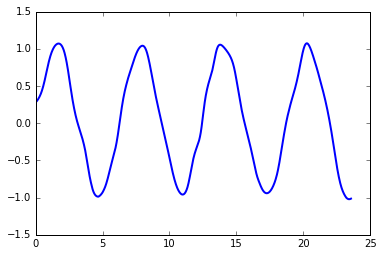

In [6]:
Y_predicted = model.predict(X, batch_size=100)
plot_x=std_scaler.inverse_transform(lins)
plot_y=mm_scaler.inverse_transform(Y_predicted)
line, = plt.plot(plot_x[0:3000:shift,0], plot_y[0:int(3000/shift),0], '-', linewidth=2)

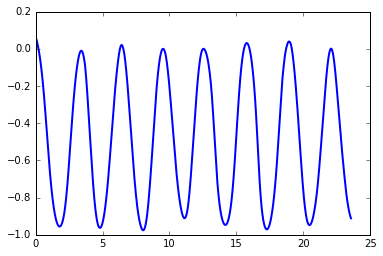

In [7]:
line, = plt.plot(plot_x[0:3000:shift,0], plot_y[0:int(3000/shift),1], '-', linewidth=2)

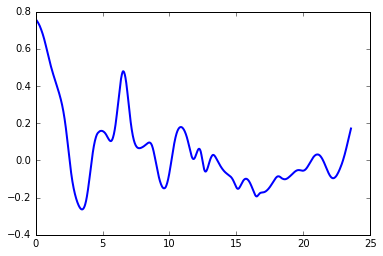

In [8]:
line, = plt.plot(plot_x[0:3000:shift,0], plot_y[0:int(3000/shift),2], '-', linewidth=2)